# Trying Variation 2.0

## 1. Adding more layers in between maxpool layers (Vgg like architecture)

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import sys
print(sys.version)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [3]:
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import datetime
import os
import torchvision
import time
import copy
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [4]:
torch.__version__

'1.7.1+cu110'

In [5]:
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader

In [6]:
# creating a function for getting training data CIFAR100

def give_me_train_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a train dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    # defining the transformations on the train data
    
    transformations = [transforms.RandomCrop(32, padding=4),
                       transforms.RandomHorizontalFlip(),
                       transforms.RandomRotation(15),
                       transforms.ToTensor(),
                       transforms.Normalize(mean, std, inplace = True)]
    transform_train = transforms.Compose(transformations)
    
    train_set = CIFAR100('./data/cifar100', train=True, 
                         download=True, transform=transform_train)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = bs,
                                               shuffle=True, num_workers=num_workers)
    return train_loader

def give_me_test_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a test dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    
    # defining transformations on the test data
    
    transformations = [transforms.ToTensor(), transforms.Normalize(mean, std, inplace=True)]
    transform_test = transforms.Compose(transformations)
    
    valid_set = CIFAR100('./data/cifar100', train=False,
                  download=True, transform=transform_test)
    val_loader = torch.utils.data.DataLoader(valid_set, batch_size=bs, shuffle=False, 
                                             num_workers=num_workers)
    return val_loader

In [7]:
mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
from numpy import dstack

def compute_mean_std(c100):

    r = np.dstack([c100[i][1][:, :, 0] for i in range(len(c100))])
    g = np.dstack([c100[i][1][:, :, 1] for i in range(len(c100))])
    b = np.dstack([c100[i][1][:, :, 2] for i in range(len(c100))])
    mean = np.mean(r), np.mean(g), np.mean(b)
    std = np.std(r), np.std(g), np.std(b)

    return mean, std

In [8]:
# Preparing our data loaders for training and test.
# Batch size is 128 (tried 256 and 512, 128 gives better performance)

train_loader = give_me_train_data(bs = 128, num_workers=4, shuffle=True)
val_loader = give_me_test_data(bs = 128, num_workers=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history, val_loss_history = [], []
    train_acc_history, train_loss_history = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_train = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        loss_train += loss.item()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                
        # decreasing learning rate with the epochs
        scheduler.step(loss_train)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [10]:
# validate the training on validation set
def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        print(name)
        print(loader)
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                
                y = model(imgs)
                _, predicted = torch.max(y, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.4f}".format(name, correct/total))
        print("{}: correct, total = {},{}".format(name, correct, total))

In [11]:
# Initialize the weights of layers.
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Trial 1: Adding Layers 33 and Layers 44 only

In [16]:
class SimpleNet(nn.Module):
    def __init__(self, in_c, n_classes):
        super(SimpleNet, self).__init__()
        kz = 3
        st = 1
        padd = 1
        self.layer1 = nn.Conv2d(in_channels = in_c, out_channels = 64, kernel_size = kz,
                                stride = st, padding = padd)
        
        self.layer2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = kz, 
                               stride = st, padding = padd)
        
        self.layer3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = kz, 
                               stride = st, padding = padd)
        self.layer33 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = kz, 
                               stride = st, padding = padd)

        self.layer4 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = kz, 
                               stride = st, padding = padd)
        self.layer44 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = kz, 
                               stride = st, padding = padd)

        self.mxpool = nn.MaxPool2d(2, 2)
        self.dense_decoder = nn.Sequential(
            nn.Linear(2048, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 1024), 
            nn.ReLU(),
            nn.Linear(1024, n_classes))
        
    def forward(self, x):

        x = F.relu(self.layer1(x))
        x = self.mxpool(x)

        x = F.relu(self.layer2(x))
        x = self.mxpool(x)

        x = F.relu(self.layer3(x))
        x = F.relu(self.layer33(x))
        x = self.mxpool(x)

        x = F.relu(self.layer4(x))
        x = F.relu(self.layer44(x))
        x = self.mxpool(x)
    
        x = x.view(x.size()[0], -1)
        x = self.dense_decoder(x)        
        return x

In [17]:
device = 'cuda'
model = SimpleNet(3, 100)
model.to(device) # sending our model to gpu.
model.apply(init_weights)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
loss_fn = nn.CrossEntropyLoss()

In [18]:
# Printing the summary of our model. 
input_shape = (3, 32, 32)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
         MaxPool2d-2           [-1, 64, 16, 16]               0
            Conv2d-3          [-1, 128, 16, 16]          73,856
         MaxPool2d-4            [-1, 128, 8, 8]               0
            Conv2d-5            [-1, 256, 8, 8]         295,168
            Conv2d-6            [-1, 256, 8, 8]         590,080
         MaxPool2d-7            [-1, 256, 4, 4]               0
            Conv2d-8            [-1, 512, 4, 4]       1,180,160
            Conv2d-9            [-1, 512, 4, 4]       2,359,808
        MaxPool2d-10            [-1, 512, 2, 2]               0
           Linear-11                 [-1, 1024]       2,098,176
             ReLU-12                 [-1, 1024]               0
           Linear-13                 [-1, 1024]       1,049,600
             ReLU-14                 [-

In [19]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 10

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/10
----------
train Loss: 4.4314 Acc: 0.0290
val Loss: 4.0616 Acc: 0.0713

Epoch 2/10
----------
train Loss: 3.8829 Acc: 0.0971
val Loss: 3.6159 Acc: 0.1464

Epoch 3/10
----------
train Loss: 3.5263 Acc: 0.1558
val Loss: 3.3080 Acc: 0.1998

Epoch 4/10
----------
train Loss: 3.2347 Acc: 0.2081
val Loss: 3.1721 Acc: 0.2265

Epoch 5/10
----------
train Loss: 3.0150 Acc: 0.2485
val Loss: 2.9071 Acc: 0.2753

Epoch 6/10
----------
train Loss: 2.8218 Acc: 0.2873
val Loss: 2.7713 Acc: 0.3028

Epoch 7/10
----------
train Loss: 2.6531 Acc: 0.3202
val Loss: 2.6610 Acc: 0.3266

Epoch 8/10
----------
train Loss: 2.4910 Acc: 0.3563
val Loss: 2.4235 Acc: 0.3731

Epoch 9/10
----------
train Loss: 2.3447 Acc: 0.3846
val Loss: 2.3192 Acc: 0.3971

Epoch 10/10
----------
train Loss: 2.2141 Acc: 0.4145
val Loss: 2.2370 Acc: 0.4143

Training complete in 2m 23s
Best val Acc: 0.414300


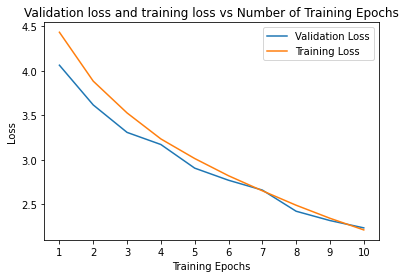

In [20]:
v_loss = [v for v in val_loss_hist]
t_loss = [t for t in train_loss_hist]

plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [21]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.4424
train: correct, total = 22121,50000
val
Accuracy val: 0.4143
val: correct, total = 4143,10000


Running for 20 more epochs to check for convergence

In [22]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 20

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/20
----------
train Loss: 2.0926 Acc: 0.4407
val Loss: 2.1501 Acc: 0.4381

Epoch 2/20
----------
train Loss: 1.9817 Acc: 0.4631
val Loss: 2.1112 Acc: 0.4448

Epoch 3/20
----------
train Loss: 1.8748 Acc: 0.4875
val Loss: 2.0718 Acc: 0.4588

Epoch 4/20
----------
train Loss: 1.7771 Acc: 0.5113
val Loss: 2.0369 Acc: 0.4665

Epoch 5/20
----------
train Loss: 1.6819 Acc: 0.5318
val Loss: 2.0363 Acc: 0.4754

Epoch 6/20
----------
train Loss: 1.5999 Acc: 0.5530
val Loss: 2.0051 Acc: 0.4736

Epoch 7/20
----------
train Loss: 1.5139 Acc: 0.5718
val Loss: 1.9571 Acc: 0.4921

Epoch 8/20
----------
train Loss: 1.4381 Acc: 0.5918
val Loss: 1.9010 Acc: 0.5088

Epoch 9/20
----------
train Loss: 1.3661 Acc: 0.6062
val Loss: 1.9551 Acc: 0.5039

Epoch 10/20
----------
train Loss: 1.2909 Acc: 0.6264
val Loss: 2.0027 Acc: 0.5081

Epoch 11/20
----------
train Loss: 1.2315 Acc: 0.6419
val Loss: 1.9755 Acc: 0.5095

Epoch 12/20
----------
train Loss: 1.1534 Acc: 0.6613
val Loss: 2.0505 Acc: 0.5072

E

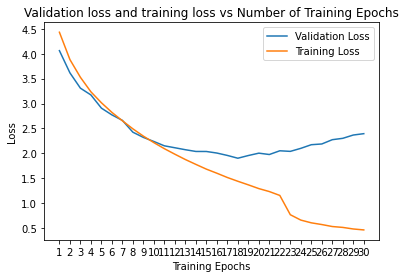

In [23]:
v_loss_1 = [v for v in val_loss_hist]
t_loss_1 = [t for t in train_loss_hist]

v_loss_30 = v_loss + v_loss_1
t_loss_30 = t_loss + t_loss_1

num_epochs = 30
plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss_30, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss_30, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

# Trial 2: Adding 1 extra conv layer with stride = 1 before each max pool layer

that is: Added Layer 11, Layer 22, Layer 33

In [12]:
class SimpleNet(nn.Module):
    def __init__(self, in_c, n_classes):
        super(SimpleNet, self).__init__()
        kz = 5
        st = 1
        padd = 2
        self.layer1 = nn.Conv2d(in_channels = in_c, out_channels = 64, kernel_size = kz,
                                stride = st, padding = padd)
        self.layer11 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = kz, 
                                stride = st, padding = padd)
        
        self.layer2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = kz, 
                               stride = st, padding = padd)
        self.layer22 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = kz, 
                                 stride = st, padding = padd)
        
        self.layer3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = kz, 
                               stride = st, padding = padd)
        self.layer33 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = kz, 
                               stride = st, padding = padd)

        self.mxpool = nn.MaxPool2d(2, 2)
        self.dense_decoder = nn.Sequential(
            nn.Linear(4096, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 1024), 
            nn.ReLU(),
            nn.Linear(1024, n_classes))
        
    def forward(self, x):

        x = F.relu(self.layer1(x))
        x = F.relu(self.layer11(x)) 
        x = self.mxpool(x)

        x = F.relu(self.layer2(x))
        x = F.relu(self.layer22(x)) 
        x = self.mxpool(x)

        x = F.relu(self.layer3(x))
        x = F.relu(self.layer33(x))
        x = self.mxpool(x)
    
        x = x.view(x.size()[0], -1)
#         print(x.shape)
        x = self.dense_decoder(x)        
        return x

In [13]:
device = 'cuda'
model = SimpleNet(3, 100)
model.to(device) # sending our model to gpu.
model.apply(init_weights)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
loss_fn = nn.CrossEntropyLoss()

In [14]:
# Printing the summary of our model. 
input_shape = (3, 32, 32)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
            Conv2d-2           [-1, 64, 32, 32]         102,464
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]         204,928
            Conv2d-5          [-1, 128, 16, 16]         409,728
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         819,456
            Conv2d-8            [-1, 256, 8, 8]       1,638,656
         MaxPool2d-9            [-1, 256, 4, 4]               0
           Linear-10                 [-1, 1024]       4,195,328
             ReLU-11                 [-1, 1024]               0
           Linear-12                 [-1, 1024]       1,049,600
             ReLU-13                 [-1, 1024]               0
           Linear-14                  [

In [15]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 10

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/10
----------
train Loss: 4.2848 Acc: 0.0465
val Loss: 3.8741 Acc: 0.0955

Epoch 2/10
----------
train Loss: 3.7121 Acc: 0.1276
val Loss: 3.4770 Acc: 0.1640

Epoch 3/10
----------
train Loss: 3.3530 Acc: 0.1905
val Loss: 3.1361 Acc: 0.2345

Epoch 4/10
----------
train Loss: 3.0859 Acc: 0.2426
val Loss: 2.9250 Acc: 0.2733

Epoch 5/10
----------
train Loss: 2.8452 Acc: 0.2858
val Loss: 2.7162 Acc: 0.3181

Epoch 6/10
----------
train Loss: 2.6333 Acc: 0.3284
val Loss: 2.5654 Acc: 0.3491

Epoch 7/10
----------
train Loss: 2.4357 Acc: 0.3699
val Loss: 2.3821 Acc: 0.3938

Epoch 8/10
----------
train Loss: 2.2635 Acc: 0.4068
val Loss: 2.2086 Acc: 0.4230

Epoch 9/10
----------
train Loss: 2.1105 Acc: 0.4393
val Loss: 2.1005 Acc: 0.4548

Epoch 10/10
----------
train Loss: 1.9680 Acc: 0.4693
val Loss: 2.0317 Acc: 0.4674

Training complete in 3m 8s
Best val Acc: 0.467400


In [16]:
v_loss = [v for v in val_loss_hist]
t_loss = [t for t in train_loss_hist]

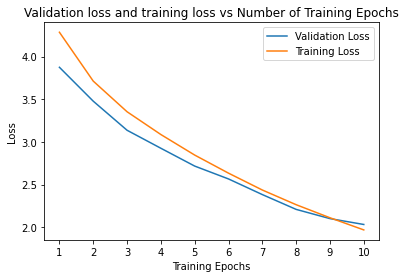

In [17]:
plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [18]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.5136
train: correct, total = 25678,50000
val
Accuracy val: 0.4674
val: correct, total = 4674,10000


# Trial 3: Adding 2 Conv Layers on top of previous architecture

i.e., 
1. Layer 4 (with ReLU) and Layer 44 (with ReLU) is added along with a MaxPool Layer. 

In [12]:
class SimpleNet(nn.Module):
    def __init__(self, in_c, n_classes):
        super(SimpleNet, self).__init__()
        kz = 5
        st = 1
        padd = 2
        self.layer1 = nn.Conv2d(in_channels = in_c, out_channels = 64, kernel_size = kz,
                                stride = st, padding = padd)
        self.layer11 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = kz, 
                                stride = st, padding = padd)
        
        self.layer2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = kz, 
                               stride = st, padding = padd)
        self.layer22 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = kz, 
                                 stride = st, padding = padd)
        
        self.layer3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = kz, 
                               stride = st, padding = padd)
        self.layer33 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = kz, 
                               stride = st, padding = padd)

        self.layer4 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = kz, 
                               stride = st, padding = padd)
        self.layer44 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = kz, 
                               stride = st, padding = padd)
        
        self.mxpool = nn.MaxPool2d(2, 2)
        self.dense_decoder = nn.Sequential(
            nn.Linear(2048, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 1024), 
            nn.ReLU(),
            nn.Linear(1024, n_classes))
        
    def forward(self, x):

        x = F.relu(self.layer1(x))
        x = F.relu(self.layer11(x)) 
        x = self.mxpool(x)

        x = F.relu(self.layer2(x))
        x = F.relu(self.layer22(x)) 
        x = self.mxpool(x)

        x = F.relu(self.layer3(x))
        x = F.relu(self.layer33(x))
        x = self.mxpool(x)

        x = F.relu(self.layer4(x))
        x = F.relu(self.layer44(x))
        x = self.mxpool(x)
        
        x = x.view(x.size()[0], -1)
#         print(x.shape)
        x = self.dense_decoder(x)        
        return x

In [13]:
device = 'cuda'
model = SimpleNet(3, 100)
model.to(device) # sending our model to gpu.
model.apply(init_weights)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
loss_fn = nn.CrossEntropyLoss()

In [14]:
# Printing the summary of our model. 
input_shape = (3, 32, 32)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
            Conv2d-2           [-1, 64, 32, 32]         102,464
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]         204,928
            Conv2d-5          [-1, 128, 16, 16]         409,728
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         819,456
            Conv2d-8            [-1, 256, 8, 8]       1,638,656
         MaxPool2d-9            [-1, 256, 4, 4]               0
           Conv2d-10            [-1, 512, 4, 4]       3,277,312
           Conv2d-11            [-1, 512, 4, 4]       6,554,112
        MaxPool2d-12            [-1, 512, 2, 2]               0
           Linear-13                 [-1, 1024]       2,098,176
             ReLU-14                 [-

In [15]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 10

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/10
----------
train Loss: 4.5900 Acc: 0.0124
val Loss: 4.4737 Acc: 0.0209

Epoch 2/10
----------
train Loss: 4.2464 Acc: 0.0456
val Loss: 4.0470 Acc: 0.0778

Epoch 3/10
----------
train Loss: 3.9252 Acc: 0.0878
val Loss: 3.7565 Acc: 0.1132

Epoch 4/10
----------
train Loss: 3.6939 Acc: 0.1246
val Loss: 3.5957 Acc: 0.1437

Epoch 5/10
----------
train Loss: 3.4739 Acc: 0.1671
val Loss: 3.3294 Acc: 0.1927

Epoch 6/10
----------
train Loss: 3.2565 Acc: 0.2049
val Loss: 3.0938 Acc: 0.2414

Epoch 7/10
----------
train Loss: 3.0474 Acc: 0.2444
val Loss: 2.8959 Acc: 0.2749

Epoch 8/10
----------
train Loss: 2.8362 Acc: 0.2850
val Loss: 2.7264 Acc: 0.3158

Epoch 9/10
----------
train Loss: 2.6572 Acc: 0.3218
val Loss: 2.6027 Acc: 0.3387

Epoch 10/10
----------
train Loss: 2.4869 Acc: 0.3540
val Loss: 2.4259 Acc: 0.3734

Training complete in 6m 33s
Best val Acc: 0.373400


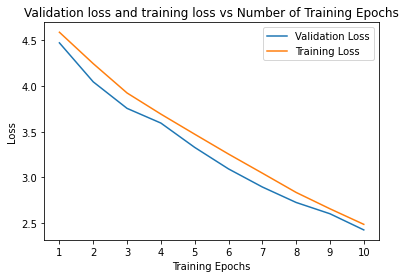

In [16]:
v_loss = [v for v in val_loss_hist]
t_loss = [t for t in train_loss_hist]

plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [17]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.3820
train: correct, total = 19101,50000
val
Accuracy val: 0.3734
val: correct, total = 3734,10000


**Running for 20 more epochs to check convergence**

In [18]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 20

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/20
----------
train Loss: 2.3186 Acc: 0.3920
val Loss: 2.3138 Acc: 0.3953

Epoch 2/20
----------
train Loss: 2.1729 Acc: 0.4215
val Loss: 2.2482 Acc: 0.4153

Epoch 3/20
----------
train Loss: 2.0335 Acc: 0.4525
val Loss: 2.2073 Acc: 0.4274

Epoch 4/20
----------
train Loss: 1.9098 Acc: 0.4825
val Loss: 2.0005 Acc: 0.4745

Epoch 5/20
----------
train Loss: 1.7900 Acc: 0.5069
val Loss: 2.0808 Acc: 0.4694

Epoch 6/20
----------
train Loss: 1.6796 Acc: 0.5306
val Loss: 1.9658 Acc: 0.4919

Epoch 7/20
----------
train Loss: 1.5888 Acc: 0.5535
val Loss: 1.9607 Acc: 0.4878

Epoch 8/20
----------
train Loss: 1.4820 Acc: 0.5803
val Loss: 2.0643 Acc: 0.4816

Epoch 9/20
----------
train Loss: 1.3955 Acc: 0.6010
val Loss: 1.8932 Acc: 0.5127

Epoch 10/20
----------
train Loss: 1.3079 Acc: 0.6212
val Loss: 1.9431 Acc: 0.5137

Epoch 11/20
----------
train Loss: 1.2345 Acc: 0.6393
val Loss: 1.9574 Acc: 0.5225

Epoch 12/20
----------
train Loss: 1.1673 Acc: 0.6588
val Loss: 2.0044 Acc: 0.5130

E

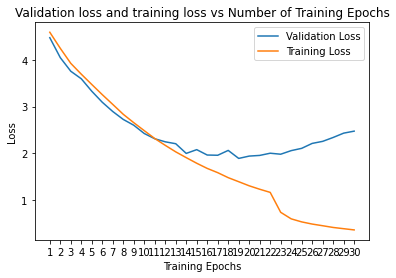

In [20]:
v_loss_1 = [v for v in val_loss_hist]
t_loss_1 = [t for t in train_loss_hist]

v_loss_30 = v_loss + v_loss_1
t_loss_30 = t_loss + t_loss_1

num_epochs = 30
plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss_30, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss_30, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

Model Starts over-fitting severly after ~17 epochs. 

In [21]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.8641
train: correct, total = 43205,50000
val
Accuracy val: 0.5625
val: correct, total = 5625,10000


# Trial 4: Added Layer 333, Layer 444

In [12]:
class SimpleNet(nn.Module):
    def __init__(self, in_c, n_classes):
        super(SimpleNet, self).__init__()
        kz = 3
        st = 1
        padd = 1
        self.layer1 = nn.Conv2d(in_channels = in_c, out_channels = 64, kernel_size = kz,
                                stride = st, padding = padd)
        self.layer11 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = kz, 
                                stride = st, padding = padd)
        
        self.layer2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = kz, 
                               stride = st, padding = padd)
        self.layer22 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = kz, 
                                 stride = st, padding = padd)
        
        self.layer3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = kz, 
                               stride = st, padding = padd)
        self.layer33 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = kz, 
                               stride = st, padding = padd)
        self.layer333 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = kz, 
                               stride = st, padding = padd)

        self.layer4 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = kz, 
                               stride = st, padding = padd)
        self.layer44 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = kz, 
                               stride = st, padding = padd)
        self.layer444 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = kz, 
                               stride = st, padding = padd)
        
        self.mxpool = nn.MaxPool2d(2, 2)
        self.dense_decoder = nn.Sequential(
            nn.Linear(2048, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 1024), 
            nn.ReLU(),
            nn.Linear(1024, n_classes))
        
    def forward(self, x):

        x = F.relu(self.layer1(x))
        x = F.relu(self.layer11(x)) 
        x = self.mxpool(x)

        x = F.relu(self.layer2(x))
        x = F.relu(self.layer22(x)) 
        x = self.mxpool(x)

        x = F.relu(self.layer3(x))
        x = F.relu(self.layer33(x))
        x = F.relu(self.layer333(x))
        x = self.mxpool(x)

        x = F.relu(self.layer4(x))
        x = F.relu(self.layer44(x))
        x = F.relu(self.layer444(x))
        x = self.mxpool(x)
        
        x = x.view(x.size()[0], -1)
        x = self.dense_decoder(x)        
        return x

In [13]:
device = 'cuda'
model = SimpleNet(3, 100)
model.to(device) # sending our model to gpu.
model.apply(init_weights)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
loss_fn = nn.CrossEntropyLoss()

In [14]:
# Printing the summary of our model. 
input_shape = (3, 32, 32)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
            Conv2d-2           [-1, 64, 32, 32]          36,928
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
            Conv2d-5          [-1, 128, 16, 16]         147,584
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
            Conv2d-8            [-1, 256, 8, 8]         590,080
            Conv2d-9            [-1, 256, 8, 8]         590,080
        MaxPool2d-10            [-1, 256, 4, 4]               0
           Conv2d-11            [-1, 512, 4, 4]       1,180,160
           Conv2d-12            [-1, 512, 4, 4]       2,359,808
           Conv2d-13            [-1, 512, 4, 4]       2,359,808
        MaxPool2d-14            [-1, 51

In [15]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 10

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/10
----------
train Loss: 4.6065 Acc: 0.0093
val Loss: 4.6053 Acc: 0.0100

Epoch 2/10
----------
train Loss: 4.6063 Acc: 0.0083
val Loss: 4.6052 Acc: 0.0100

Epoch 3/10
----------
train Loss: 4.6062 Acc: 0.0092
val Loss: 4.6052 Acc: 0.0100

Epoch 4/10
----------
train Loss: 4.6061 Acc: 0.0087
val Loss: 4.6052 Acc: 0.0100

Epoch 5/10
----------
train Loss: 4.6060 Acc: 0.0088
val Loss: 4.6052 Acc: 0.0100

Epoch 6/10
----------
train Loss: 4.6059 Acc: 0.0094
val Loss: 4.6051 Acc: 0.0099

Epoch 7/10
----------
train Loss: 4.6057 Acc: 0.0089
val Loss: 4.6046 Acc: 0.0126

Epoch 8/10
----------
train Loss: 4.5947 Acc: 0.0140
val Loss: 4.5031 Acc: 0.0196

Epoch 9/10
----------
train Loss: 4.3527 Acc: 0.0272
val Loss: 4.2390 Acc: 0.0419

Epoch 10/10
----------
train Loss: 4.1358 Acc: 0.0489
val Loss: 3.9998 Acc: 0.0704

Training complete in 3m 9s
Best val Acc: 0.070400


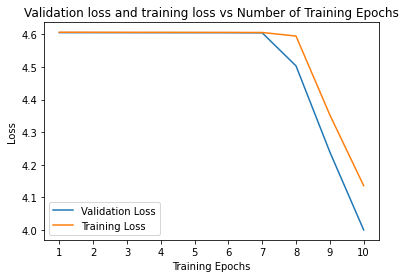

In [16]:
v_loss = [v for v in val_loss_hist]
t_loss = [t for t in train_loss_hist]

plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [17]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.0679
train: correct, total = 3397,50000
val
Accuracy val: 0.0704
val: correct, total = 704,10000
